# 10 - Cython and Swig

[0 - Why python is slow](#zero)
[1 - Python Decorators](#one)  
[2 - Cython](#two)  
[3 - For those about Fortran: F2PY](#three)  
[4 - SWIG: the Simple Wrapper Interface Generator](#four)  

In [1]:
from IPython.display import Image

In [2]:
import importlib as imp
import matplotlib.pyplot as plt
import numpy as np
import math

from re import search

%matplotlib inline
%load_ext Cython

In [3]:
%alias clean rm -f *.c *.exe *.py *.pyc *.s .*f95 *.o *.fo *log *.h *.cc *.mod

In [4]:
%clean

<a id="zero"></a>

# Why Python is slow

If you like to be pendantic, we should remember that Python is a *standard* with *different implementations* as the  [Python web site](#https://wiki.python.org/moin/Why%20is%20Python%20slower%20than%20the%20xxx%20language) remembers us. 

But then, *why running a for loop in CPython is slower than C?*

### Duck typing

Take the difference of C variable vs a Python one at runtime: 

- the C variable is just a pointer to some array location with few definite properties
- the Python variable is a "box" containing an instance of a subclass of **object**

when the code executes, the Python interpreter decides what properties the variable may have depending *on context*. The following C code:

    int i,j,k;
    i = 2;
    j = 2;
    k = i*j;
    return k
    
means the CPU will use approximately seven cycles. 

The Python equivalent:

    i = 2
    j = 2
    k = i*j
    return k
    
involves the following operations on the **PyObject** (see below) C structures:

- creating the objects i, j and k
- assigning the appropriate attibutes
- selecting the method for the '\*' operator
- calculating the result and the appropriate type for k
  
and each of these operations means that the interpreter creates or uses something like that: 

    typedef struct _object {
    _PyObject_HEAD_EXTRA
    Py_ssize_t ob_refcnt;
    struct _typeobject *ob_type;
    } PyObject;

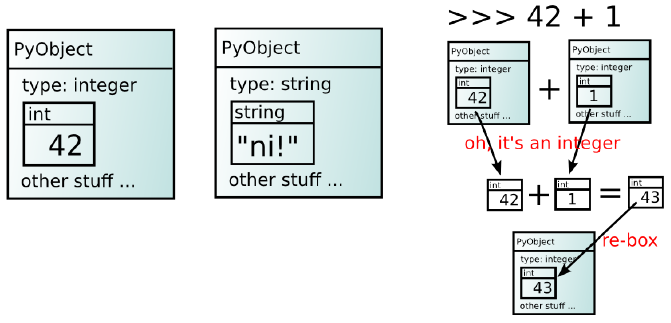

In [5]:
Image(filename="pictures/box.png")

### Bytecode

From Wikipedia:

Bytecode, also known as p-code (portable code), is a form of instruction set designed for efficient execution by a software interpreter. Unlike human-readable source code, bytecodes are compact numeric codes, constants, and references (normally numeric addresses) which encode the result of parsing and semantic analysis of things like type, scope, and nesting depths of program objects. They therefore allow much better performance than direct interpretation of source code.

### Interpreted language

Again, from Wikipedia, an interpreter may be a program that either
1. executes the source code directly
2. translates source code into some efficient intermediate representation (code) and immediately executes this
3. explicitly executes stored precompiled code made by a compiler which is part of the interpreter system

Note that, in principle, almost any language can be *compiled* or *interpreted*, it depends on whether you have (or write) a compiler program or an interpreter one. What does the **python** (using CPython on Linux) command do when you execute `python somescript.py` ?

In [6]:
%%writefile hello_mod.py
def hello():
	print("Hello, World!")

Writing hello_mod.py


In [7]:
%%writefile hello_script.py
import hello_mod

hello_mod.hello()

quit()

Writing hello_script.py


In [8]:
%%bash
python3 ./hello_script.py
ls -rt __pycache__

Hello, World!
myfirstdecorator.cpython-35.pyc
hello_mod.cpython-35.pyc


the **.pyc** is a *bytecode*, so python is in case 2 above. The Python interpreter loads .pyc files before .py files, so if they're present, it can save some time by not having to re-compile the Python source code.

*But how this affects execution speed?*

Compared to an interpreter, a good compiler can look ahead and optimize the code (remove redundant operation, unrolling small loops). This may be guided by user selected switches, yielding a significant speed-up. However, compilation may be a difficult task by itself, requiring knowledge of the platform and compiler being used.

The **[dis](#https://docs.python.org/3.5/library/dis.html)** module allows you to dissassemble your Python bytecode.

### Locality

One of the key features of Numpy is the locality of data that allows to access to rows and columns as C (or Fortran) plus the decoration that make possible all the fancy stuff. The values in the array are **contiguous** and have a common size.

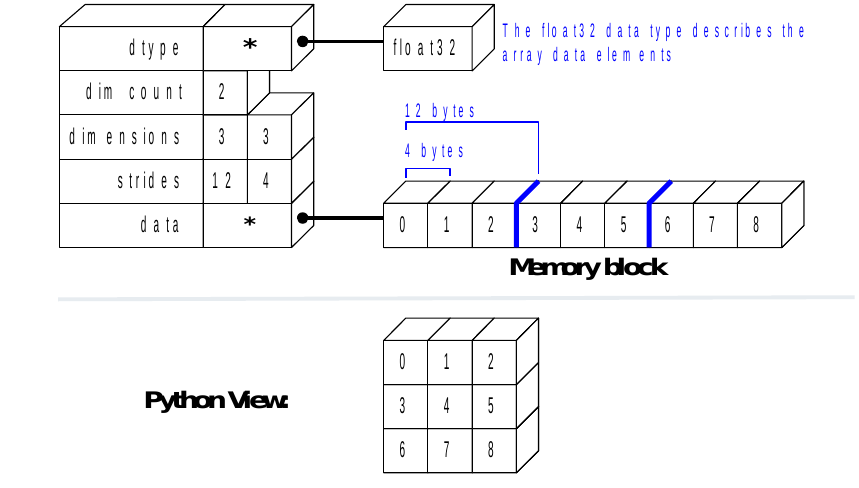

In [9]:
Image("pictures/array.png")

A list object in CPython is represented by the following C structure. **ob_item** is an array of pointers to the list elements. **allocated** is the number of slots allocated in memory

    typedef struct {
	    PyObject_VAR_HEAD
	    PyObject **ob_item;
	    Py_ssize_t allocated;
	} PyListObject;

each element in the Python list is found by a pointer to a buffer of pointers, each of which points to a Python object which encapsulates its own data. Thus, operations like *append* or *pop* are cheap but running over all the elements in the list can be costly since it involves a great deal of referencing operations and (likely) a lot of copies to and from the memory.

<a id="one"></a>

# Python Decorators

Python functions are objects themselves and can be the object of assignment:

In [10]:
def foo():
    print("Alpha","Bravo","Charlie")
foo

<function __main__.foo>

In [11]:
baz = foo
baz

<function __main__.foo>

In [12]:
baz()

Alpha Bravo Charlie


Suppose we define a function within another function definition:

In [13]:
def change_repr(arg1):
    assert isinstance(arg1,int)
    def binary(arg1):
        print(bin(arg1))
        return bin(arg1)
    def hexa_dec(arg1):
        print(hex(arg1))
        return hex(arg1)
    binary(arg1)
    hexa_dec(arg1)

In [14]:
a = change_repr(10)
print("Returned value ",a)

0b1010
0xa
Returned value  None


`binary` and `hexa_dec` are defined in the local scope of `change_repr` and not available outside of it.  
Recall the Python sequence of scopes: **Local**, **Enclosing**, **Global**, **Built-in** (**LEGB**).  
It is also possible to pass function as parameters to other functions:

In [15]:
def change_repr(arg, func):
    if isinstance(arg,int):
        return func(arg)
    else:
        return func(int(arg))
def binary(arg1):
    assert isinstance(arg1,int)
    print("Binary representation")
    return bin(arg1)

In [16]:
a = change_repr(10, binary)
print("Returned value ",a)

Binary representation
Returned value  0b1010


In [17]:
binary(10.2)

AssertionError: 

In [18]:
change_repr(10.2, binary)

Binary representation


'0b1010'

Hence, `change_repr` is a sort of *wrapper* that checks input correctness for `binary` and modifies its behaviour.  
The former can be used to create a more fault tolerant version of the latter.  
We can have an even more flexible than that since function can be also *returned*. 

In [19]:
def hexa_dec(arg1):
    assert isinstance(arg1,int)
    return hex(arg1)

def change_repr(func):
    def newfunc(arg):
        arg = int(arg)
        return func(arg)
    return newfunc

In [20]:
hexa_dec = change_repr(hexa_dec)
hexa_dec

<function __main__.change_repr.<locals>.newfunc>

In [21]:
hexa_dec(10.2)

'0xa'

In [22]:
hex(10.2)

TypeError: 'float' object cannot be interpreted as an integer

we call this function that modifies the behaviour of another function a *decorator*.  One problem we have with this approach is that we have lost information on the true nature of `hexa_dec` (see also above).  

In [23]:
%%writefile myfirstdecorator.py
def change_repr(func):
    def wrapper(arg):
        arg = int(arg)
        return func(arg)
    return wrapper

Writing myfirstdecorator.py


In [24]:
import myfirstdecorator

hexa_dec = myfirstdecorator.change_repr(hexa_dec)
print(hexa_dec.__name__, hexa_dec.__module__)
print(binary.__name__, binary.__module__)

wrapper myfirstdecorator
binary __main__


this however can be easily solved reassigning the `__name__` and `__module__` (and others like `__doc__`) attributes:

In [25]:
%%writefile myfirstdecorator.py
def change_repr(func):
    def wrapper(arg):
        arg = int(arg)
        return func(arg)
    wrapper.__name__ = func.__name__
    wrapper.__module__ = func.__module__
    return wrapper

Overwriting myfirstdecorator.py


In [26]:
imp.reload(myfirstdecorator)

def hexa_dec(arg1):
    assert isinstance(arg1,int)
    return hex(arg1)
hexa_dec = myfirstdecorator.change_repr(hexa_dec)
hexa_dec(10.2)
print(hexa_dec.__name__, hexa_dec.__module__)

hexa_dec __main__


python provides a simplified syntax and a library, called **wraps**, to simplify the development and use of decorators:

In [27]:
%%writefile myfirstdecorator.py
from functools import wraps

def change_repr(func):
    @wraps(func)
    def wrapper(arg):
        arg = int(arg)
        return func(arg)
    return wrapper

Overwriting myfirstdecorator.py


In [28]:
imp.reload(myfirstdecorator)

@myfirstdecorator.change_repr
def hexa_dec(arg1):
    assert isinstance(arg1,int)
    return hex(arg1)

hexa_dec(10.2)
print(hexa_dec.__name__, hexa_dec.__module__)

hexa_dec __main__


### Exercise 0

1. Write functions and decorators to create a *polynomial factory* that returns an object able to evaluate:  
$$ \sum_{k=1}^N a_k x^k $$

 with an arbitrary list of non zero parameters and exponents.

2. Create a *profile decorator* that keeps track of the number of calls and elapsed time for a generic function. Use a relatively expensive function for testing, such as the formula by Srinivasa Ramanujan (see also [here](#https://en.wikipedia.org/wiki/Pi#Approximate_value)) can be used to estimate $\pi$:

$$ \frac{1}{\pi} = \frac{2\sqrt{2}}{9801} \sum_{k=0}^{\infty} \frac {(4k!)(1103+26390 k)} {(k!)^4 (396)^{4k}} $$

 you may implement it with a convergence criterion based on the value of the last term computed of `1e-15`; test against `math.pi`.

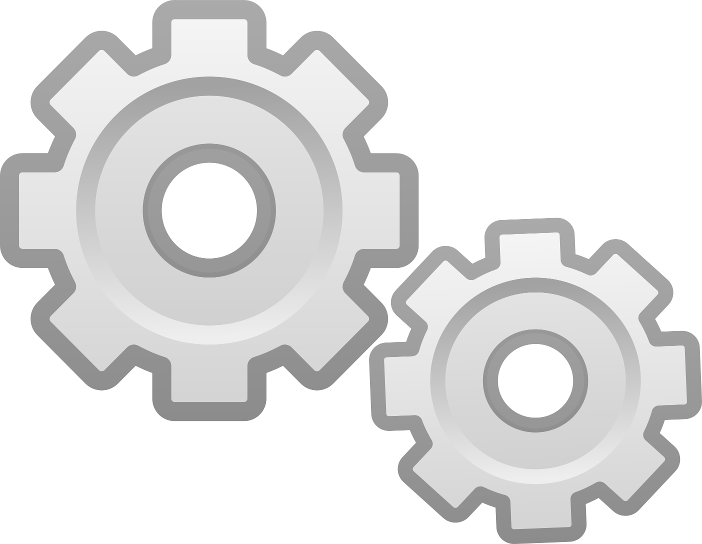

In [29]:
Image("pictures/gears.png")

### Solution 0

** 1 **

In [30]:
def factory(*args):
    def myfunc(x):
        y = 0.
        for coeff, expn in args:
            y += coeff * (x ** expn)
        return y
    return myfunc

In [31]:
myf = factory((6.,6.), (10.,10.), (12.,12.))
myf(1.2)

186.82647360307192

** 2 **

In [32]:
from datetime import datetime

def profile(func):
    def wrapper(*args, **kwargs):
        t0 = datetime.now()
        wrapper.count += 1
        return func(*args, **kwargs), (datetime.now()-t0).total_seconds()
    wrapper.count   = 0
    wrapper.el_time = 0
    return wrapper

In [33]:
# credits to http://greenteapress.com/wp/think-python/

@profile
def estimate_pi():
    """Computes an estimate of pi.

    Algorithm due to Srinivasa Ramanujan, from 
    http://en.wikipedia.org/wiki/Pi
    """
    total = 0
    k = 0
    const = 2. * math.sqrt(2.) / 9801.
    while True:
        num = math.factorial(4*k) * (1103 + 26390*k)
        den = math.factorial(k)**4 * 396**(4*k)
        term = const * num / den
        total += term       
        if abs(term) < 1e-15: break
        k += 1
    return 1. / total

In [34]:
for i in range(3):
    print(estimate_pi())
estimate_pi.count

(3.141592653589793, 3e-05)
(3.141592653589793, 3.7e-05)
(3.141592653589793, 2.9e-05)


3

<a id="two"></a>

# Cython

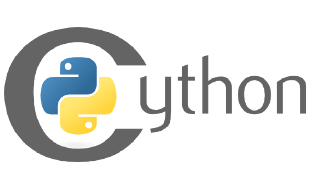

In [35]:
Image("pictures/cy_logo.png")

The fundamental nature of Cython can be summed up as follows: Cython is Python with C data types. This means that Cython can handle at the same type:

- almost any native Python code
- intermixed C and Python variable and commands

what happens: the Cython compiler reads in a .pxy file and produces a .c file; the C file is compiled; the resulting module is linked against the CPython library, and used by the interpreter

More precisely (from the documentation):

*Cython is an optimising static compiler for both the Python programming language and the extended Cython programming language. 
The Cython language is a superset of the Python language that additionally supports calling C functions and declaring C types on variables and class attributes. This allows the compiler to generate very efficient C code from Cython code. The C code is generated once and then compiles with all major C/C++ compilers.*

So, that's your world without Cython'

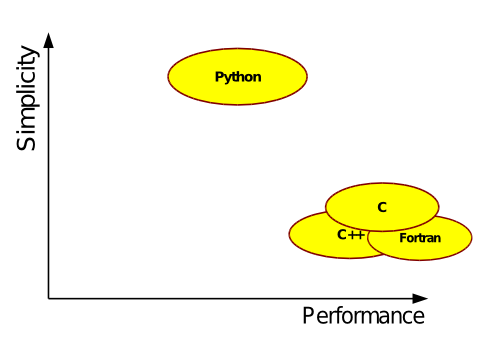

In [36]:
Image("pictures/wo_cython.png")

With Cython:

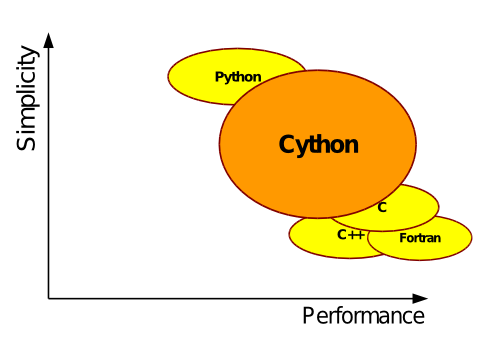

In [37]:
Image("pictures/wcy.png")

### Summing integers

What if we want to use Cython? Generally speaking, this should include a compilation step, converting the Cython code to C.  In the following, we will take advantage of the `%%cython` cell magic to pass compilation options to cython.

In [38]:
%%cython
def mymultiply(int a,int b):
    cdef int c = a*b
    return c
try:
    mymultiply("w","q")
except TypeError as e:
    print(e)
finally:
    print(mymultiply(3.,4.))

an integer is required
12


**cdef** may be used to declare C types and structures (and also **union** and **enum** types). **cdef** may also be used to declare functions and classes (known as extensions, behave like a builtin) with C attributes which are then callable from C. **cpdef** puts a Python wrapper around a C function definition and makes it callable from C and Python.

- def func(int x):  
    *caller passes Python object x*  
    *function converts to C int on entry*  
    *implicit return type always object*  
    
    
- cdef int func(int x):  
    *caller converts arguments as required*  
    *function receives C an int*  
    *arbitrary return type, defaults to object*  
    
    
- cpdef int func(int x):  
    *a C version of the function is generated as with cdef*  
    *a Python version is also generated and available to the interpreter (converting Ctypes to objects when returning functions)*

In [39]:
%%timeit
%%cython
n = int(1e6)
cdef int j = 0
cdef int i
for i in range(n): 
    j += i

The slowest run took 7.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 259 µs per loop


In [40]:
%%timeit
j = 0
for i in range(int(1e6)): 
    j += i

10 loops, best of 3: 65.8 ms per loop


Note that **C** variables are *not* python objects, i. e. they are typed:

In [41]:
%%cython
cdef int n
n = 10.


Error compiling Cython file:
------------------------------------------------------------
...
cdef int n
n = 10.
   ^
------------------------------------------------------------

/home/g.mancini/.cache/ipython/cython/_cython_magic_ef31c55f21da49e43efda6fd9d4d6f03.pyx:2:4: Cannot assign type 'double' to 'int'


raises an error, while

In [42]:
%%cython
cdef double d
d = 10

does an automatic casting

### Calculate $\pi$ (yeah, again)

**Pure Python version**

In [43]:
def pi_py(npoints):
    step  = 1./npoints
    mysum = 0.
    for i in range(npoints):
        x = (i+0.5)*step
        mysum += 4./(x*x + 1.)
    return step*mysum

In [44]:
%%capture py_out
%timeit pi_py(int(1e6))

**NumPy version**

In [45]:
def pi_numpy(npoints):
    grid = np.linspace(0, 1, num=npoints, endpoint=False)
    x    = 4./(1. + grid**2)
    return (1./npoints)*np.sum(x)

In [46]:
%%capture numpy_out
%timeit pi_numpy(int(1e6))

**C version**

In [47]:
%%writefile pi.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
int main (int argc, char **argv) {
    int num_steps = argv[1] != NULL ? atoi(argv[1]) : 1E6;
    int nrun = 10;
    double step, x, t0, time = 0., PI = 0.;
    step = 1.0/(double) num_steps;
    
    for(int i = 0; i< nrun; i++)
    {
        t0 = omp_get_wtime();
        for (int j = 0; j < num_steps; j++)
        {
            x = (j + 0.5) * step;
            PI = PI + 4.0/(1.0 + x * x);
        }
        PI = step * PI;
        time += omp_get_wtime() - t0;
    }
    printf("PI, mean time: %f ms",1000.*(time / (double) num_steps));
    return 0;
}

Writing pi.c


In [48]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 pi.c -o pi.exe -fopenmp

In [49]:
%%capture C_out
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
./pi.exe

**Cython version**

In [50]:
%%cython -a --compile-args=-O2
def pi_cy(int npoints):
    #everything down here is a C variable
    cdef double x, step = 1./(<int> npoints), PI = 0.
    cdef int i = 0
    for i in range(npoints):
        x = (i + 0.5) * step
        PI += 1./ (1. + x*x)
    return 4. * PI * step

Invoking Cython (had we built a module using *python setup.py ...*) generates about 1000 lines of C code which is then compiled and used when running cpi.cpi(). I.e. Cython has generate a **valid C code** which exposes itself to Python and is not so bad compared to C.

In [51]:
pi_cy(int(1e6))

3.1415926535897643

In [52]:
%%capture cy_out
%%timeit
pi_cy(int(1e6))

In [53]:
cy_out.stdout

'100 loops, best of 3: 6.17 ms per loop\n'

Text(0,0.5,'Elapsed time (ms)')

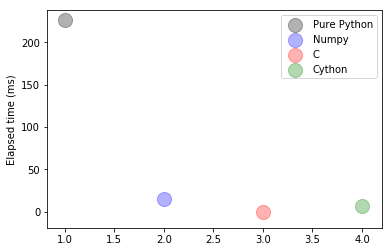

In [54]:
pat = r'(.*):\s(.*)\sms'
times = [ search(pat, i.stdout).group(2) for i in (py_out, numpy_out, C_out, cy_out)]
times = list(map(float,times))
scale = 200
colour = ("k","b","r","g","m")
for point,method in enumerate(("Pure Python","Numpy","C","Cython")):
    plt.scatter(point+1,times[point],label=method,c=colour[point],s=scale,edgecolor=None,alpha=0.3)
plt.legend()
plt.ylabel("Elapsed time (ms)")

Which seems to imply that *if **i** is declared as a cdef integer type, it will optimise this into a pure C loop.*  

To sum up, just using **`%%cython`** and **`cdef`** yields performance an order of magnitude less than C, but we have Numpy not pure Python.  
It is foreseeable that often we will pass numpy arrays to Cython functions.  
It is possible to use Numpy arrays and Cython?

### compiler options from command line



To use OpenMP we have to both pass options to compiler the actual compiler invoked by cython using `--compile-args=ARGS`.  
In the same way we can add other linking, preprocessor and compiler options and path to build C executables, even if 
a jupyter notebook is not very handy for that (better would be to build Cython modules from the console then import and use them). Options available are (see also the [official documentation](#https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiling-with-a-jupyter-notebook)):

| option | use |
|--------|-----|
|-a, | –annotate	Produce a colorized HTML version of the source.|
|-+, | –cplus	Output a C++ rather than C file.|
|-f, | –force	Force the compilation of a new module, even if the source has been previously compiled.|
|-3	| Select Python 3 syntax|
|-2	| Select Python 2 syntax|
|-c=COMPILE_ARGS, –compile-args=COMPILE_ARGS	| Extra flags to pass to compiler via the extra_compile_args.|
|–link-args LINK_ARGS	| Extra flags to pass to linker via the extra_link_args.|
|-l LIB, –lib LIB	| Add a library to link the extension against (can be specified multiple times).|
|-L dir	| Add a path to the list of library directories (can be specified multiple times).|
|-I INCLUDE, –include INCLUDE	| Add a path to the list of include directories (can be specified multiple times).|
|-S, –src	| Add a path to the list of src files (can be specified multiple times).|
|-n NAME, –name NAME	| Specify a name for the Cython module.|
|–pgo	| Enable profile guided optimisation in the C compiler. Compiles the cell twice and executes it in between to generate a runtime profile.|
|–verbose	| Print debug information like generated .c/.cpp file location and exact gcc/g++ command invoked.|

### some useful decorators

there are also some Cython specific compiler directives that affect the interaction between C and Python. They can be specified in the building files or using decorators. Below there are just two examples. See also [here](#https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiler-directives).  

**`@cdivision (True / False)`**  
If set to False, Cython will adjust the remainder and quotient operators C types to match those of Python ints (which differ when the operands have opposite signs) and raise a ZeroDivisionError when the right operand is 0. This has up to a 35% speed penalty. If set to True, no checks are performed. See CEP 516. **Default is False.**

**`@boundscheck (True / False)`**  
If set to False, Cython is free to assume that indexing operations ([]-operator) in the code will not cause any IndexErrors to be raised. Lists, tuples, and strings are affected only if the index can be determined to be non-negative (or if wraparound is False). Conditions which would normally trigger an IndexError may instead cause segfaults or data corruption if this is set to False. **Default is True.**  

### Integration with Monte Carlo

A common example of MC integration is to compute $\pi$ by sampling random numbers as x and y coordinates, and counting how many of them were in the unit circle. The basic idea is that the ratio of the area of the unit circle to the square that inscribes it is $\pi/4$, so by counting the fraction of the random points in the square that are inside the circle, we may estimate $\pi$. 

In [55]:
npoints = 20000
#unit circle centered in .0, .0
x = 2.*np.random.rand(npoints)-1
y = 2.*np.random.rand(npoints)-1
r = x**2+y**2
# fancy indexing
inside = r[r<1.]
print("# of points inside ",inside.shape)

# of points inside  (15672,)


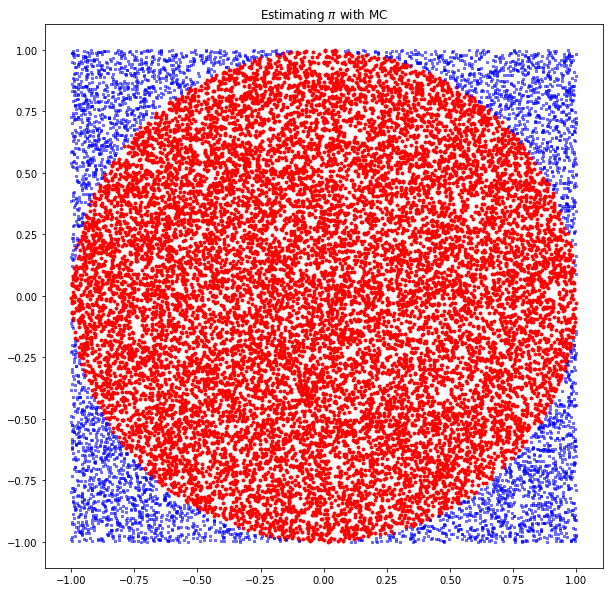

In [56]:
plt.figure(figsize=(10,10))
plt.title("Estimating $\pi$ with MC")
plt.scatter(x[r<1],y[r<1],marker='h',s=10,color='r')
plt.scatter(x[r>1],y[r>1],marker='s',s=5,color='b',alpha=0.5)

### Numpy arrays and memoryviews

Try MC integration and compare Cython and Numpy versions (we assume Pure Python is slower).  

**Numpy**

In [57]:
def mc_numpy(npoints):   
    x = 2.*np.random.rand(npoints)-1.
    y = 2.*np.random.rand(npoints)-1.
    r = x*x + y*y
    r = r[ r<=1.]
    inside = r.shape[0]
    return 4.0 * inside / npoints

In [58]:
mc_numpy(int(1e7))

3.141884

In [59]:
%%capture mc_np
%%timeit
mc_numpy(int(1e7))

In [60]:
mc_np.stdout

'1 loop, best of 3: 455 ms per loop\n'

**Cython** using only C scalars

In [61]:
%%cython --compile-args=-O2
import numpy as np
from cython import cdivision

@cdivision(True)
def mc_cy_1(int npoints):
    cdef double x, y, inside = 0. 
    cdef int i
    for i in range(npoints):
        x = 2. * np.random.random() - 1.
        y = 2. * np.random.random() - 1.
        if x*x + y*y <= 1.:
            inside += 1
    return 4.0 * (inside / <double> npoints)

In [62]:
mc_cy_1(int(1e7))

3.141886

In [63]:
%%capture cy1
%%timeit 
mc_cy_1(int(1e7))

In [64]:
cy1.stdout

'1 loop, best of 3: 7.27 s per loop\n'

**Cython** using numpy arrays for x and y

In [65]:
%%cython --compile-args=-O2
import numpy as np
from cython import cdivision, boundscheck

@boundscheck(False)
@cdivision(True)
def mc_cy_2(int npoints):
    cdef double inside = 0. 
    cdef int i
    #x and y are Numpy arrays
    x = 2.*np.random.rand(npoints)-1.
    y = 2.*np.random.rand(npoints)-1.
    for i in range(npoints):
        if x[i]*x[i] + y[i]*y[i] <= 1.:
            inside += 1
    
    return 4.0*inside / <double> npoints

In [66]:
mc_cy_2(int(1e7))

3.1416492

In [67]:
%%capture cy2
%%timeit 
mc_cy_2(int(1e7))

In [68]:
cy2.stdout

'1 loop, best of 3: 4.88 s per loop\n'

Text(0,0.5,'Elapsed time (ms)')

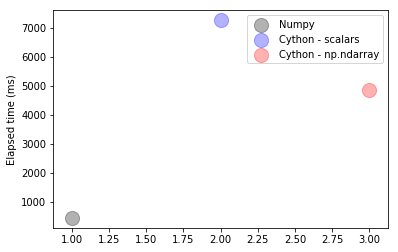

In [69]:
pat = r'(.*):\s(.*)\s(m|)s'
#pat = r'(.*)\s(ms|s)\s\+'
#times = [ search(pat, i).group(1) for i in (mc_np.stdout, cy1.stdout, cy2.stdout)]
times = [ search(pat, i).group(2) for i in (mc_np.stdout, cy1.stdout, cy2.stdout)]
times = np.array(list(map(float,times)))
times[1:] = 1000.*times[1:]
scale = 200
colour = ("k","b","r","g","m")
for point,method in enumerate(("Numpy","Cython - scalars","Cython - np.ndarray")):
    plt.scatter(point+1,times[point],label=method,c=colour[point],s=scale,edgecolor=None,alpha=0.3)
plt.legend()
plt.ylabel("Elapsed time (ms)")

Why is that? The reason is that working with NumPy arrays incurs substantial Python overheads.  
The same hold for calling from inside a *almost pure C* function a Python function.  
Cython’s **typed memoryviews**, which provide more direct access to arrays in memory.
Like a standard numpy array view (e. g. a slice object) a **memoryview** stores information on a memory location without holding it. Being typed, the cython compiler can access it as it would with a standard C array, avoiding interpreter overhead.

When using them, the first step is to create a NumPy array and then  declare a memoryview and bind it to the NumPy array.

In [70]:
%%cython --compile-args=-O2
import numpy as np
from cython import cdivision, boundscheck
from numpy cimport float_t

@boundscheck(False)
@cdivision(True)
def mc_cy_3(int npoints):
    cdef double inside
    cdef int i
    x = 2. * np.random.rand(npoints) - 1.
    y = 2. * np.random.rand(npoints) - 1.
    cdef float_t [:] X = x
    cdef float_t [:] Y = y
    for i in range(npoints):
        if X[i]*X[i] + Y[i]*Y[i] <= 1.:
            inside += 1.
    return 4. * inside / <double> npoints

In [71]:
mc_cy_3(int(1e7))

3.142026

In [72]:
%%capture cy3
%%timeit 
mc_cy_3(int(1e7))

In [73]:
cy3.stdout

'1 loop, best of 3: 420 ms per loop\n'

**Memoryviews and numpy calls outside Cython functions**

In [74]:
%%cython --compile-args=-O2
import numpy as np
from cython import cdivision, boundscheck
from numpy cimport float_t

@boundscheck(False)
@cdivision(True)
def mc_cy_4(int npoints, X, Y):
    cdef double inside
    cdef int i
    cdef float_t [:] x = X
    cdef float_t [:] y = Y
    for i in range(npoints):
        if x[i]*x[i] + y[i]*y[i] <= 1.:
            inside += 1.
    return 4. * inside / <double> npoints

In [75]:
x = 2. * np.random.rand(int(1e7)) - 1.
y = 2. * np.random.rand(int(1e7)) - 1.
mc_cy_4(x.shape[0], x, y)

3.1416332

In [76]:
%%capture cy4
%%timeit
x = 2. * np.random.rand(int(1e7)) - 1.
y = 2. * np.random.rand(int(1e7)) - 1.
mc_cy_4(x.shape[0], x, y)

In [77]:
cy4.stdout

'1 loop, best of 3: 368 ms per loop\n'

Text(0,0.5,'Elapsed time (ms)')

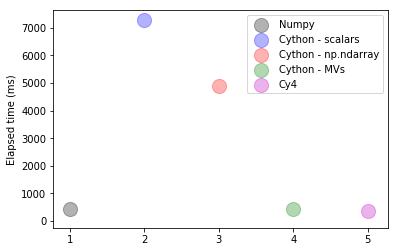

In [78]:
pat = r'(.*):\s(.*)\s(m|u|)s'
#pat = r'(.*)\s(ms|s)\s\+'
#times = np.append(times,float(search(pat, cy3.stdout).group(1)))
times = np.append(times,float(search(pat, cy3.stdout).group(2)))
times = np.append(times,float(search(pat, cy4.stdout).group(2)))
times = np.array(list(map(float,times)))
scale = 200
colour = ("k","b","r","g","m")
for point,method in enumerate(("Numpy","Cython - scalars","Cython - np.ndarray","Cython - MVs","Cy4")):
    plt.scatter(point+1,times[point],label=method,c=colour[point],s=scale,edgecolor=None,alpha=0.3)
plt.legend()
plt.ylabel("Elapsed time (ms)")

Note that memoryviews supports a number of operations, including copy, in analogy with arrays:
    new_mv[:] = old_mv   
or
    new_mv[...] = old_mv
for all dimensions

The **`cimport`** statement is analogous to the Python **`import`** but works for Cython modules but for importing **C functions** from C libraries. E. g.:

In [79]:
%%cython
from libc.stdlib cimport atoi

cdef parse_charptr_to_py_int(char* s):
    assert s is not NULL, "byte string value is NULL"
    return atoi(s)  # note: atoi() has no error detection!

From the documentation (bold is mine):
A Cython module can be split into two parts: a definition file with a **.pxd** suffix, containing *C declarations* that are to be available to other Cython modules, and an implementation file with a **.pyx** suffix, containing everything else. When a module wants to use something declared in another module’s definition file, it imports it using the **`cimport`** statement.

A **.pxd** file that consists *solely of extern declarations* does not need to correspond to an actual .pyx file or Python module. This can make it a convenient place to put common declarations, for example declarations of functions from an external library that one wants to use in several modules.

In [80]:
!ls /usr/lib64/python3.5/site-packages/Cython/Includes/

Deprecated  cpython  libc  libcpp  numpy  openmp.pxd  posix


In [81]:
!ls /usr/lib64/python3.5/site-packages/Cython/Includes/numpy

__init__.pxd  math.pxd


In [82]:
%%bash
cd /usr/lib64/python3.5/site-packages/Cython/Includes/numpy
grep " float_t"  __init__.pxd 

ctypedef npy_double     float_t


In [83]:
%%bash
pwd

/home/g.mancini/Dropbox/teach/calcolo_2018/10_mixl


In [84]:
%%cython
cdef extern from "string.h":
    int strlen(char *c)
def get_len(char *message):
    return strlen(message)

In [85]:
get_len(bytearray("Jena Plinskeen",encoding="ascii"))

14

### The Global Interpreter Lock

Python can use threads, but they can't be used to increase performance: only one Python instruction is allowed to run at any time. This is the **Global Interpreter Lock** (GIL). Each time a thread executes a Python statement, a lock is acquired which prevents other threads to run until it is released. The GIL avoids conflicts between threads, simplifying the implementation of the CPython (Jython and IronPython have no GIL) interpreter. Despite this limitation, threads can still be used to provide concurrency in situations where the lock can be released, such as in time-consuming I/O operations or in C extensions.

#### Release the GIL and using OpenMP

Cython supports native parallelism with OpenMP; it is also possible to MPI (e.g. with mpi4py) and it should be possible to exploit Cython to interface with C code using MPI or pthreads (not easy).  
To use *all these kinds of parallelism*, we must *release the GIL*. Note that the GIL is released whenever using low-level C-code (e. g. with a multithreaded BLAS or ATLAS; but you have to build numpy against it).

To use OpenMP within Cython you have to:

1. Look into the **`cython.parallel`** module

2. Release the GIL before a block of code:
        with nogil:
        \# This block of code is executed after releasing the GIL
        
        with gil:
        \#this block of code will enable the GIL in a no-GIL context (kind of omp atomic or serial)
               
3. Parallelize for-loops with **`prange`**:
        from cython.parallel import prange

**`prange`** is a (sort of) short-hand Cython equivalent for:

    #pragma omp parallel for private(i)
    for(i = 1;i < N; i++)
    {
        ...
    }
        
Note that any in-place operation is automatically taken to be a reduction variable, which means that the thread local values are combined after all threads have completed. Further, the index variable is always **lastprivate**, i.e. it will hold the value of the last thread executed. 

- lastprivate: Specifies that the enclosing context's version of the variable is set equal to the private version of whichever thread executes the final iteration (for-loop construct) or last section (#pragma sections).

- firstprivate: Specifies that each thread should have its own instance of a variable, and that the variable should be initialized with the value of the variable, because it exists before the parallel construct.

In [86]:
%%cython --compile-args=-fopenmp --compile-args=-O2 --compile-args=-march=native --compile-args=-mtune=native --link-args=-fopenmp 

from cython import cdivision
from cython.parallel import prange

@cdivision(True)
def pi_cy_omp(int npoints,int NT=1):
    """
    another version of arctg integration using Cython and realising the GIL
    """
    cdef double x, mysum=.0, step=1. / npoints
    cdef int i
    # this is the equivalent of #pragma omp or !$OMP
    for i in prange(npoints, nogil=True, schedule='static', num_threads=NT):
        x = (i+0.5)*step
        mysum += 4.0/(x*x + 1.0)
        
    return mysum*step

In [87]:
pi_cy_omp(int(1e7))

3.141592653589731

In [88]:
%%capture t1
%timeit pi_cy_omp(int(1e7),1)

In [89]:
%%capture t2
%timeit pi_cy_omp(int(1e7),2)

In [90]:
%%capture t4
%timeit pi_cy_omp(int(1e7),4)

In [91]:
%%capture t6
%timeit pi_cy_omp(int(1e7),6)

In [92]:
%%capture t8
%timeit pi_cy_omp(int(1e7),8)

[61.5, 34.5, 15.9, 10.6, 8.69]

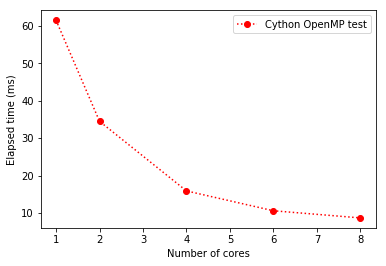

In [93]:
x   = np.array((1,2,4,6,8))
pat = r'(.*):\s(.*)\s(s|ms)'
#pat = r'(.*)\s(ms|s)\s\+'
cy = list()
for i in (t1,t2,t4,t6,t8):
    res = search(pat,i.stdout)
    cy.append(float(res.group(2)))
    #if res.group(2) is "s":
    if res.group(3) is "s":
        cy[-1] = cy[-1]*1e3
cy = list(map(float,cy))
plt.plot(x,cy,marker='o',color='r',ls=':',label="Cython OpenMP test")
plt.legend()
plt.xlabel("Number of cores")
plt.ylabel("Elapsed time (ms)")
cy

### Exercise 1 

Write a multithreaded version of MonteCarlo integration.  
Hint: beware of random numbers in parallel contexts.  

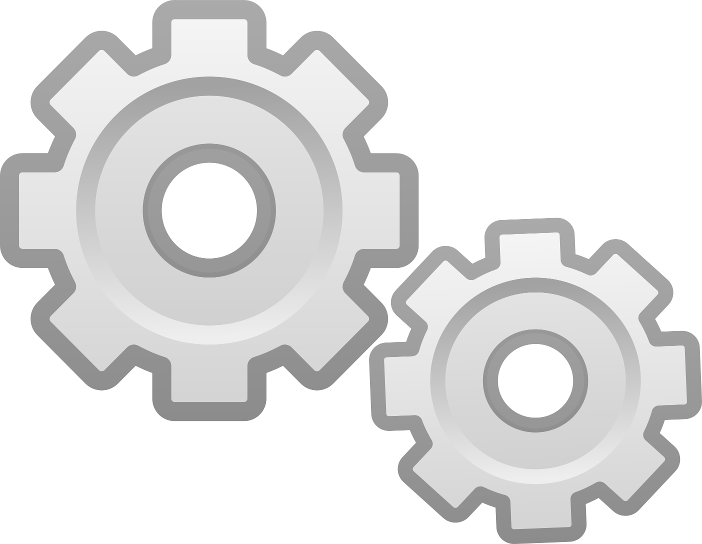

In [94]:
Image("pictures/gears.png")

### Solution 1

In [95]:
%%cython --compile-args=-fopenmp --compile-args=-O2 --compile-args=-march=native --compile-args=-mtune=native --link-args=-fopenmp 

from cython import cdivision, boundscheck, wraparound
from cython.parallel import parallel, prange
from numpy cimport float_t, ndarray

@wraparound(False)
@boundscheck(False)
@cdivision(True)
def mc_cy_5(int npoints, int NT, ndarray X, ndarray Y):
    cdef float_t [:] x = X
    cdef float_t [:] y = Y
    cdef int i, inside = 0
    cdef double a, b
    with nogil, parallel(num_threads=NT):
        for i in prange(npoints, schedule='guided', chunksize=1000):
            a = (2. * x[i] -1.)
            b = (2. * y[i] -1.)      
            if a*a + b*b <= 1.:
                inside += 1    
    return 4. * <double> inside / <double> npoints

In [96]:
X = np.random.rand(int(1e7))
Y = np.random.rand(int(1e7))
mc_cy_5(int(1e7),1,X,Y)

3.1416904

In [97]:
%%timeit
X = np.random.rand(int(1e7))
Y = np.random.rand(int(1e7))
mc_cy_5(int(1e7),1,X,Y)

1 loop, best of 3: 313 ms per loop


In [98]:
X = np.random.rand(int(1e8))
Y = np.random.rand(int(1e8))

In [99]:
%%capture cy5_nt1
%%timeit
mc_cy_5(int(1e7),1,X,Y)

In [100]:
%%capture cy5_nt2
%%timeit
mc_cy_5(int(1e7),2,X,Y)

In [101]:
%%capture cy5_nt4
%%timeit
mc_cy_5(int(1e7),4,X,Y)

In [102]:
%%capture cy5_nt6
%%timeit
mc_cy_5(int(1e7),6,X,Y)

In [103]:
%%capture cy5_nt8
%%timeit
mc_cy_5(int(1e7),8,X,Y)

In [104]:
cy5_nt8.stdout

'100 loops, best of 3: 7.55 ms per loop\n'

Text(0,0.5,'Elapsed time (ms)')

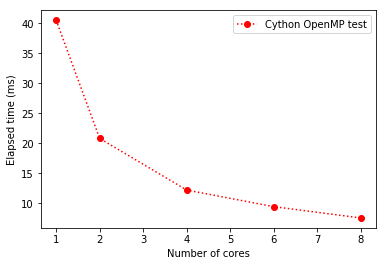

In [105]:
x   = np.array((1,2,4,6,8))
pat = r'(.*):\s(.*)\s(s|ms)'
#pat = r'(.*)\s(ms|s)\s\+'
cy = list()
for i in (cy5_nt1, cy5_nt2, cy5_nt4, cy5_nt6, cy5_nt8):
    res = search(pat,i.stdout)
    cy.append(float(res.group(2)))
cy = list(map(float,cy))
plt.plot(x,cy,marker='o',color='r',ls=':',label="Cython OpenMP test")
plt.legend()
plt.xlabel("Number of cores")
plt.ylabel("Elapsed time (ms)")

### Other relevant topics (not covered)

1. How to compile Cython **`*pyx`** files.  
2. How to build Python / Cython modules.  
3. Pyximport.  
4. Using classes with Cython.  
5. Cython and C++.  

<a id="three"></a>

# 3 - For those about Fortran: F2PY

The purpose of the [F2PY](#http://docs.scipy.org/doc/numpy-dev/f2py/) –Fortran to Python interface generator– project is to provide a connection between Python and Fortran languages. F2PY is a Python package (with a command line tool, **f2py** and a module, **f2py2e** that facilitates creating/building Python C/API extension modules.

[Jacobi solver](#http://mathworld.wolfram.com/JacobiMethod.html): given a [diagonally dominant matrix](#https://en.wikipedia.org/wiki/Diagonally_dominant_matrix) **A** and a vector **b**, solve:

$$ Ax = b $$

by iterating:

$$ x_i^{(k+1)} = \frac {b_i - \sum_{i \ne j} A_{ij} x_j^{(k)} } {A_{ii}} $$.

We can write a Fortran subroutine to do the calculations, testing that the algorithm has converged by calculating every (nth) step:

$$ conv = \sum_i (x_i^{(k+1)} - x_i^{(k)})^2 $$

and comparing against a preset tolerance. We may also check the error as:
 $$ err_i = b_i - \sum_{j} A_{ij}x_j $$

and

$$ err = \frac {\sqrt {\sum_i err_i^2}} {n} $$

Generate input and testing function with Python:

In [106]:
def gen_jac(dim=1000,tol=1e-10):
    """
    generate starting data for Jacobi solver exercise
    """
    A = np.random.rand(dim*dim) + tol
    A.shape = (dim,dim) 
    b = np.random.rand(dim) + tol
    x_0 = np.random.rand(dim) + tol
    for i in range(dim):
        A[i,i] = 1.5*(np.sum(A[i,:i])+np.sum(A[i,i:]))
    return A,b,x_0

In [107]:
def test_jac(A,b,x,debug=False):
    """
    test Jacobi solver
    """
    dim = A.shape[0]

    mysum = np.zeros(dim)
    for i in range(dim):
        mysum[i] = b[i] - np.sum(A[i,:]*x)
    
    err = math.sqrt(np.sum(mysum**2)/dim)
    if not debug:
        return err
    else:
        return err,mysum

In [108]:
A,b,x_0 = gen_jac(1000)
A.shape

(1000, 1000)

Provide a pure Python version for comparison:

In [109]:
def solv_jac(A,b,xold,tol=1e-8,kmax=100):
    """
    Jacobi solver
    """
    dim = A.shape[0]
    xnew = np.ones(dim)
    k = 0
    conv = kmax
    
    while (k<kmax and conv>tol):
        for i in range(dim):
            xtmp = .0
            for j in range(dim):
                if i != j:
                    xtmp += xold[j] * A[i,j]
            xnew[i] = (b[i] - xtmp)/A[i,i]
        conv = .0
        for i in range(dim):
            conv += (xnew[i] - xold[i])**2

        xold = np.copy(xnew)
        k += 1

    return k,conv,xnew

In [110]:
nk, conv, xnew = solv_jac(A,b,x_0)
err = test_jac(A,b,xnew)
print(nk,err,conv)

32 0.0014018515195604086 7.8721232898e-09


In [111]:
%timeit solv_jac(A,b,x_0)

1 loop, best of 3: 13.5 s per loop


Write the F95 module

In [112]:
%%writefile jac_solv.f95
 module fjac
 use omp_lib
 contains
 subroutine jacsolv(kmax,A,b,xold,conv,xnew,order)
 implicit none

 integer :: order
 real(8) :: t0, t1
 real(8), dimension(0:order-1,0:order-1) :: A
 real(8), dimension(0:order-1) :: xold,b
 real(8), dimension(0:order-1) :: xnew
 !f2py intent(in)    order
 !f2py intent(out)   xnew
 !f2py depend(order) xnew
 
 integer :: i, k, kmax
 !f2py intent(in,out) kmax
 real(8) :: conv, tol
 !f2py intent(out) conv
 real(8), dimension(0:order-1) :: dd, xtmp
 real(8), dimension(0:order-1, 0:order-1) :: R, D

 conv  = kmax
 tol   = 1e-8

 xtmp = xold
 xnew = 1.
 forall (i=0:size(dd)-1) D(i,i) = A(i,i)
 forall (i=0:size(dd)-1) dd(i)   = 1.d0/A(i,i)
 R = A-D

 t0 = omp_get_wtime()
 do k=1,kmax
     conv = 0.
     !$OMP parallel do private(i)
     do i = 0,order-1
         xnew(i) = (b(i) - DOT_PRODUCT(xtmp,R(i,:)) )*dd(i)
     end do
     !$OMP end parallel do
     conv = SUM((xnew-xtmp)*(xnew-xtmp))

     if (conv <= tol) then
         exit
     end if

     xtmp = xnew
 end do
 !end loop on k
 t1 = omp_get_wtime()
 write(*,*) 'wall time for k-loop: ',1000.d0*(t1-t0)
 
 kmax = k
 
 end subroutine
 end module fjac

Writing jac_solv.f95


This is quite standard Fortran 95 code, with the exception of the **!f2py** lines which are preprocessor directives (like the \#pragma ones).

Instead of directly calling *gfortran* we use f2py to generate the appropriate wrapping code and then compile:

In [113]:
%%bash
source /home/g.mancini/Dropbox/Slackware/gcc_vars.sh
rm -f fjac.cpython-35m-x86_64-linux-gnu.so
f2py -c --fcompiler=gnu95 --opt="-Wall -O2 -ftree-vectorize -fopt-info-vec-optimized -fopenmp" \
--arch="-march=native -mtune=native -msse4.2" -lgomp  jac_solv.f95 -m fjac

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "fjac" sources
f2py options: []
f2py:> /tmp/tmpfdnry7jd/src.linux-x86_64-3.5/fjacmodule.c
creating /tmp/tmpfdnry7jd/src.linux-x86_64-3.5
Reading fortran codes...
	Reading file 'jac_solv.f95' (format:free)
Post-processing...
	Block: fjac
			Block: fjac
In: :fjac:jac_solv.f95:fjac
get_useparameters: no module omp_lib info used by fjac
				Block: jacsolv
In: :fjac:jac_solv.f95:fjac:jacsolv
get_useparameters: no module omp_lib info used by jacsolv
Post-processing (stage 2)...
	Block: fjac
		Block: unknown_interface
			Block: fjac
				Block: jacsolv
Building modules...
	Building module "fjac"...
		Constructing F90 module support for "fjac"...
			Constructing wrapper function "fjac.jacsolv"...
			  kmax,conv,xnew = jacsolv(kmax,a,

In [114]:
%%writefile run_fjac.py
import fjac
import numpy as np
print(fjac.__doc__)
def gen_jac(dim=1000,tol=1e-10):
	A = np.random.rand(dim*dim) + tol
	A.shape = (dim,dim) 
	b = np.random.rand(dim) + tol
	x_0 = np.random.rand(dim) + tol
	for i in range(dim):
		A[i,i] = 1.5*(np.sum(A[i,:i])+np.sum(A[i,i:]))
	return A,b,x_0

A,b,x_0 = gen_jac(10000)

nk, conv, xnew = fjac.fjac(100,A,b,x_0,A.shape[0])
print(nk,conv)

Writing run_fjac.py


In [115]:
%%timeit
%%bash
source /home/g.mancini/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=1 python3 run_fjac.py

 wall time for k-loop:    9982.0362690006732     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.266041710820541e-09
 wall time for k-loop:    10028.479471999162     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.3081234785109e-09
 wall time for k-loop:    10032.197399999859     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.40265331421905e-09
 wall time for k-loop:    10050.233616002515     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.382475025056398e-09
1 loop, best of 3: 13 s per loop


In [116]:
%%timeit
%%bash
source /home/g.mancini/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=4 python3 run_fjac.py

 wall time for k-loop:    3367.9223830004048     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.3833892399880845e-09
 wall time for k-loop:    3408.3065619997797     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.25767453039426e-09
 wall time for k-loop:    3167.9891659987334     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.364280433730662e-09
 wall time for k-loop:    3167.3410609982966     
This module 'fjac' is auto-generated with f2py (version:2).
Functions:
Fortran 90/95 modules:
  fjac --- jacsolv().
35 7.329950133291398e-09
1 loop, best of 3: 5.93 s per loop


<a id="four"></a>

# 4 - The simple Wrapper Interface Generator (SWIG)

From the documentation:

[SWIG](#http://www.swig.org/) is a software development tool that connects programs written in C and C++ with a variety of high-level programming languages. SWIG is used with different types of target languages including common scripting languages such as Javascript, Perl, PHP, Python, Tcl and Ruby.

When using SWIG you have to create an interface file (**.i**) which is similar to a header file and tells to the **swig** program how to relate Python objects to C/C++ types in the module. The **.i** file is used in the compilation step to produce C/C++ files encapsulating C/C++ files for the high level language. 

Even if "less flexible" than Cython or F2py is also a more general and sometimes easier tool since to use and also let you to interface the same low-level code with multiple interfaces.

A simple example:

    %module testswig
    %{
    #include "test.h"
    %}
    %include "test.h"
    
the **%module** specifies the name of the module to be generated from this wrapper file. The code between the **%{ %}** is placed, verbatim, in the C output file.

An interface for SWIG and Numpy [used to be distributed with Numpy](#http://docs.scipy.org/doc/numpy/reference/swig.interface-file.html) and can be now found [here](#https://github.com/numpy/numpy/tree/master/tools/swig). To estimate $\pi$ using MonteCarlo by passing Numpy arrays to an underlying C function we need:

1. a SWIG interface file (**.i**)
2. a C module
3. a Makefile

In [117]:
%cd swig
%clean

/home/g.mancini/Dropbox/teach/calcolo_2018/10_mixl/swig


In [118]:
%%writefile swigmc.c
#include <stdio.h>
#include <stdlib.h>
#include "swigmc.h"

double calcpi(double *x, double *y, int npoints){

    int    i, inside=0;
    double r2, pi;
    for(i=0;i<npoints;i++){
        r2 = x[i]*x[i] + y[i]*y[i];
        if(r2<=1.0){
            inside++;
        }
    }

    pi = (4.0* ((double) inside))/ ((double) npoints);
    printf("%f %f\n",x[0],y[0]);
    return pi;
}

Writing swigmc.c


In [119]:
%%writefile swigmc.h
double calcpi(double *x, double *y, int npoints);

Writing swigmc.h


In [120]:
%%writefile swigmc.i
%module swigmc
%{
#define SWIG_FILE_WITH_INIT
#include <stdio.h>
#include <stdlib.h>
#include "swigmc.h"
%}

%include "numpy.i"

%init %{
import_array();
%}

%apply (int DIM1, double* IN_ARRAY1) {(int npx, double* x)};
%apply (int DIM1, double* IN_ARRAY1) {(int npy, double* y)};

%inline %{
        double swigpi(int npx, double* x, int npy, double* y){
                printf("%f %f\n",x[0],y[0]);
                double PI;
                PI = calcpi(x,y,npx);
                return PI;
        }
%}

Overwriting swigmc.i


In [121]:
%%writefile Makefile
#Makefile for xdrlib with python SWIG interface
#Giordano Mancini Sept 2012
CC     = gcc
CFLAGS = -O2 -Wall -march=native -mtune=native -msse4.2 -fPIC
F77    = gfortran
FFLAGS = $(CFLAGS)
SHELL  = /bin/sh
OBJECTS = swigmc.o
INCLUDE = swigmc.h 
CPPFLAGS = -I/usr/include/python2.7 -I/usr/lib64/python2.7/site-packages/numpy/core/include/ \
-I/usr/lib/python2.7/site-packages/numpy/core/include/
SWIG     = swig 
SWIGOPT  = -python -Wall
SWIGOBJS = swigmc_wrap.o

all: clean swigmc

swigmc: $(OBJECTS) $(SWIGOBJS)
	$(CC) -shared -o _swigmc.so $(OBJECTS) $(SWIGOBJS)

swigmc_wrap.c: swigmc.i
	$(SWIG) $(SWIGOPT) swigmc.i
	
swigmc_wrap.o: swigmc_wrap.c
	$(CC) $(CFLAGS) $(CPPFLAGS) -c swigmc.c swigmc_wrap.c

clean:
	rm -f *.so *.o *.pyc swigmc_wrap.c *py *gch
	
.SUFFIXES : .c .h .o

.c.o:
	$(CC) $(INCLUDE) $(CFLAGS) -c $*.c

Overwriting Makefile


In [122]:
!make clean && make

rm -f *.so *.o *.pyc swigmc_wrap.c *py *gch
rm -f *.so *.o *.pyc swigmc_wrap.c *py *gch
gcc swigmc.h  -O2 -Wall -march=native -mtune=native -msse4.2 -fPIC -c swigmc.c
swig  -python -Wall swigmc.i
gcc -O2 -Wall -march=native -mtune=native -msse4.2 -fPIC -I/usr/include/python2.7 -I/usr/lib64/python2.7/site-packages/numpy/core/include/ -I/usr/lib/python2.7/site-packages/numpy/core/include/ -c swigmc.c swigmc_wrap.c
In file included from /usr/lib64/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1777:0,
                 from /usr/lib64/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /usr/lib64/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from swigmc_wrap.c:2972:
/usr/lib64/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using dep

In [123]:
%%writefile test.PY
import numpy as np
import swigmc

npoints = int(1e7)
x = 2.*np.random.rand(npoints)-1
y = 2.*np.random.rand(npoints)-1
print(x[0],y[0])

pi = swigmc.swigpi(x,y)
print(pi)

Overwriting test.PY


In [124]:
%%bash
#module load python-2.7
python test.PY

(0.63593799344543656, 0.7604598030935239)
0.635938 0.760460
0.635938 0.760460
3.1421728


In [125]:
%cd ..

/home/g.mancini/Dropbox/teach/calcolo_2018/10_mixl
